# Heterogeneous flow

The best way to run `foxes` calculations on heterogeneous background flow fields is by providing them in `netCDF` format. The following coordinates are supported (can be `None` if not present):

- A state coordinate, e.g. `Time` (expected by default) or `state`, or similar
- A height coordinate, e.g. `height` (expected by default) or `h`, or similar
- A `y` coordinate, e.g. `UTMY` (expected by default) or `y`, or similar
- A `x` coordinate, e.g. `UTMX` (expected by default) or `x`, or similar

The file may contain any kind of `foxes` variables as data fields, e.g.:

- Wind speed data, e.g. `WS` (expected by default, if claimed as output variable), `ws` or similar
- Wind direction data, e.g. `WD` (expected by default, if claimed as output variable), `wd` or similar
- Turbulence intensity data, e.g. `TI` (expected by default, if claimed as output variable), `ti` or similar
- Air density data, e.g. `RHO` (expected by default, if claimed as output variable), `rho` or similar

All data must depend on the state coordinate, and may depend on the others.

These are the required imports for this example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import foxes
import foxes.variables as FV

/home/jonas/gits/wakes/foxes/foxes/core/engine.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


For parallelization we will use the following engine:

In [2]:
engine = foxes.Engine.new("process")

One very simple example for `netCDF` type data is provided in the static data, under the name `wind_rotation.nc`. It contains two states, two heights, and simple 2 x 2 horizontal data that describes identical wind speeds at all four corner points associated with different wind direction values. It can be loaded as follows:

In [3]:
states = foxes.input.states.FieldData(
    data_source="wind_rotation.nc",
    states_coord="state",
    x_coord="x",
    y_coord="y",
    h_coord="h",
    time_format=None,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2ncvar={FV.WS: "ws", FV.WD: "wd"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.1},
    load_mode="preload",
    bounds_extra_space=1000,
    interp_pars=dict(bounds_error=False),
)

The `bounds_extra_space` parameter is here set to 1000 meters. Alternatively, distances can be specified as multiples of the rotor diameter as string, e.g., `2D`. If not `None` this cuts the input data spatially to the specified extension of the wind farm boundary area.

Note that it is recommended that the `states` object should be created outside the `Engine` context when working with NetCFD input.

Now back to our example. Let's place a simple 3 x 3 grid wind farm inside the data domain, which is a rectangle between `(0, 0)` and `(2500, 2500)`:

In [4]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm,
    xy_base=np.array([500.0, 500.0]),
    step_vectors=np.array([[500.0, 0], [0, 500.0]]),
    steps=(3, 3),
    turbine_models=["NREL5MW"],
    verbosity=0,
)

The streamline following wakes are realized by selecting a `wake frame` that is an instance of `foxes.models.wake_frames.Streamlines2D`, e.g. the model `streamlines_100_l3` in the model book. This model has a streamline step size of 100 m and a maximal streamline length of 3 km:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="grid16",
    wake_models=["Jensen_linear_k007"],
    wake_frame="streamlines_100_l3",
    verbosity=0,
)

We run the algorithm, once explicitely for calculating the wind farm data, and once implicitely when creating horizontal flow plots:

ProcessEngine: Calculating 2 states for 9 turbines
ProcessEngine: Starting calculation using 191 workers, for 2 states chunks.


  0%|          | 0/2 [00:00<?, ?it/s]

ProcessEngine: Completed all 2 chunks

                       WD  AMB_REWS      REWS        AMB_P            P
state turbine                                                          
0     0        201.161374  7.491089  7.491089  1474.211485  1474.211485
      1        208.049068  7.673386  7.673386  1580.523149  1580.523149
      2        214.528482  7.960601  7.960601  1748.171150  1748.171150
      3        218.247782  6.867298  6.867298  1127.597890  1127.597890
      4        222.303122  7.283373  7.283373  1352.715592  1352.715592
      5        225.904091  7.731909  6.812258  1614.607094  1102.830918
      6        236.756151  6.932726  6.932726  1156.958724  1156.958724
      7        237.144204  7.375640  7.375640  1406.547921  1406.547921
      8        237.488280  7.818854  7.818854  1665.346938  1665.346938
1     0         20.310811  6.703701  5.738961  1054.871497   651.260571
      1         26.260025  6.995899  5.942901  1185.898437   719.019801
      2         31.680276

  0%|          | 0/382 [00:00<?, ?it/s]

ProcessEngine: Completed all 382 chunks



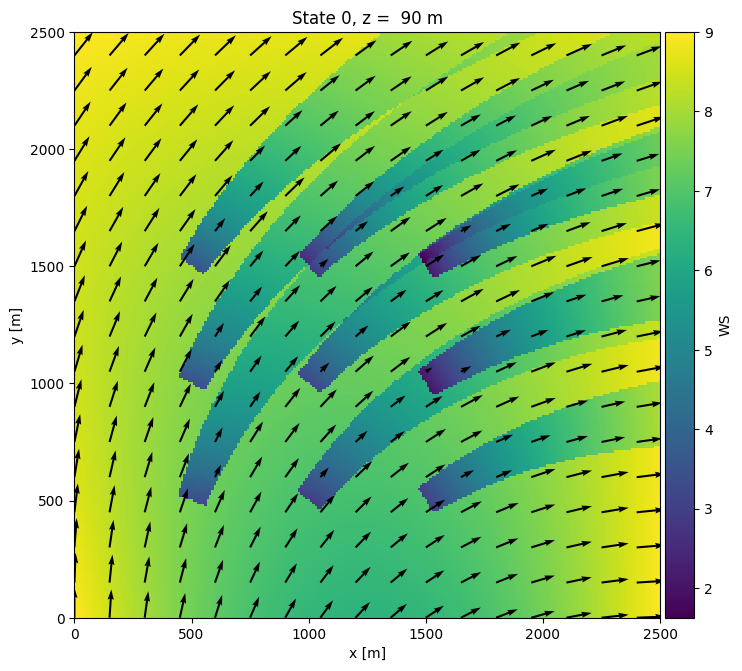

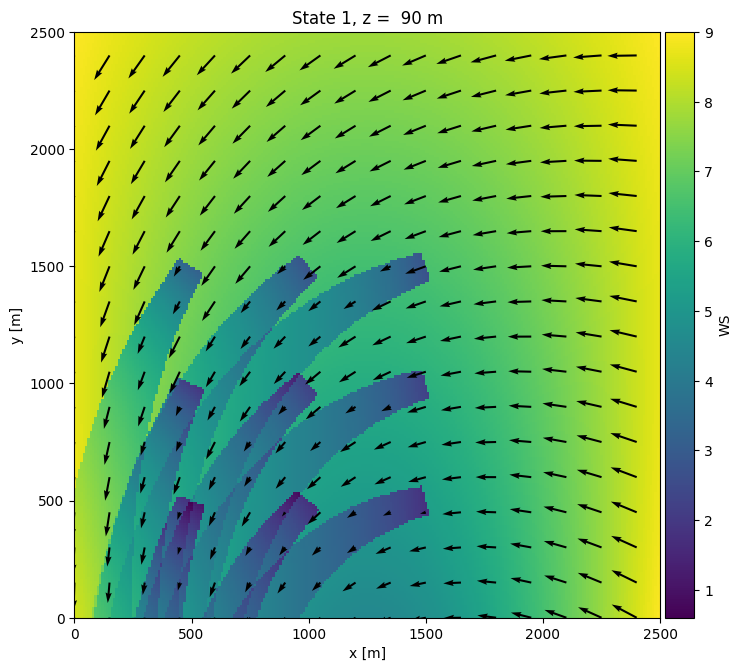

In [6]:
with engine:
    farm_results = algo.calc_farm()

    fr = farm_results.to_dataframe()
    print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

    o = foxes.output.FlowPlots2D(algo, farm_results)
    plot_data = o.get_states_data_xy(
        FV.WS,
        resolution=10,
        xmin=0,
        xmax=2500,
        ymin=0,
        ymax=2500,
    )

for fig in o.gen_states_fig_xy(
    plot_data,
    figsize=(8, 8),
    quiver_pars=dict(angles="xy", scale_units="xy", scale=0.07),
    quiver_n=15,
):
    plt.show()
    plt.close(fig)